## Redes sociais - APS(1)
Fernando Fincatti, Gabriela Moreno e Beatriz Bernardino

---

### Import libraries
---

In [1]:
import pandas as pd
import csv
from graph_tool import Graph
import os
from graph_tool import util
from netpixi.data.gt import *
import netpixi

### Auxiliary functions
---

In [2]:
def filter_by_year(path, year):
    """
        Receives the path for the dataset (csv) and the year that must be filter
        Return a list containing all the data to the desired year.
    """
    
    response = [] #list grouping all rows
    with open(path) as file:
        reader = csv.reader(file, delimiter=',', quotechar='"')
        i = 0;
        for row in reader:
            if i != 0: #jumps the header
                match_year = str(row[3]).split('/')[2] #get match year
                if match_year == year:
                    response.append(row)
            i += 1
        
    return response    

In [3]:
def create_player_list(data):
    """
    Receives a list with all data
    Return a list with all unique players names
    """
    
    jogadores = []
    for listas in data_2015:
        jogadores.append(listas[15])
        jogadores.append(listas[17])
    
    #eliminate duplicate players
    jogadores = list(dict.fromkeys(jogadores))
    return jogadores

In [4]:
def edges_list(data):
    """
    Receives a list with all data
    Return a list with all edgs and dict with match ocurrency
    """
    
    lista_vencedor_perdedor=[] #list to store all edgs
    dict_vencedor_perdedor = {} #dict to store occurecy
    for valores in data:
        lista=[]
        lista.append(valores[13]) #add winner to list
        if valores[13] == valores[15]:
            lista.append(valores[17])
        else:
            lista.append(valores[15])
        chave = valores[15]+"_"+valores[17] #dict key to identify players match
        if chave in dict_vencedor_perdedor:
            dict_vencedor_perdedor[chave] += 1 #increment match occurency
        else:
            dict_vencedor_perdedor[chave] = 1
            lista_vencedor_perdedor.append(lista)
    return lista_vencedor_perdedor, dict_vencedor_perdedor

In [5]:
def create_edgs_links(v_p_list, v_p_dict, g):
    """
    Receives a list with sublists [winner, looser], a dictionary with the match occurency and the fork
    Create the edges and its proprieties
    """
    
    indice = 0
    for dupla in v_p_list:
        vencedor = dupla[0]
        perdedor = dupla[1]
        
        str_index_vencedor = util.find_vertex(g,g.vp['nome'],vencedor) 
        index_vencedor = int(str(str_index_vencedor).split(" ")[4].replace("'","")) #get winner index
        
        str_index_perdedor = util.find_vertex(g,g.vp['nome'],perdedor) 
        index_perdedor = int(str(str_index_perdedor).split(" ")[4].replace("'","")) #get looser index
        
        g.add_edge(index_vencedor, index_perdedor) #add edge to fork
        
        e = g.edge(index_vencedor, index_perdedor) #get the correct edge
        g.ep['vitorias'][e] = v_p_dict[vencedor+'_'+perdedor]
        indice+=1

### Analysing the dataset
---

In [6]:
df = pd.read_csv(r'./ATP Dataset_2012-01 to 2017-07_Int.csv')

In [7]:
df.head()

,ATP,Tournament,Tournament_Int,Date,Series,Series_Int,Court,Court_Int,Surface,Surface_Int,...,Winner,Winner_Int,Player1,Player1_Int,Player2,Player2_Int,Player1_Rank,Player2_Rank,Player1_Odds,Player2_Odds
0,1,BrisbaneInternational,1.2757,1/1/17,ATP250,2.9693,Outdoor,3.6494,Hard,4.4983,...,ThompsonJ.,6.7926,ThompsonJ.,6.7926,YmerE.,6.0375,79.0,160.0,1.29,3.50
1,1,BrisbaneInternational,1.2757,1/2/17,ATP250,2.9693,Outdoor,3.6494,Hard,4.4983,...,MahutN.,6.9297,MahutN.,6.9297,RobertS.,6.9152,39.0,54.0,1.54,2.43
2,1,BrisbaneInternational,1.2757,1/2/17,ATP250,2.9693,Outdoor,3.6494,Hard,4.4983,...,FerrerD.,6.3881,FerrerD.,6.3881,TomicB.,6.6345,21.0,26.0,2.01,1.77
3,1,BrisbaneInternational,1.2757,1/2/17,ATP250,2.9693,Outdoor,3.6494,Hard,4.4983,...,EdmundK.,6.8384,EdmundK.,6.8384,EscobedoE.,6.1645,45.0,141.0,1.37,3.01
4,1,BrisbaneInternational,1.2757,1/2/17,ATP250,2.9693,Outdoor,3.6494,Hard,4.4983,...,DimitrovG.,6.5157,DimitrovG.,6.5157,JohnsonS.,6.1087,17.0,33.0,1.41,2.85


In [8]:
df.describe()

,ATP,Tournament_Int,Series_Int,Court_Int,Surface_Int,Round_Int,Best_of,Winner_Int,Player1_Int,Player2_Int,Player1_Rank,Player2_Rank,Player1_Odds,Player2_Odds
count,14746.000000,14746.000000,14746.000000,14746.000000,14746.000000,14746.000000,14746.000000,14746.000000,14746.000000,14746.000000,14740.000000,14714.000000,14735.000000,14735.000000
mean,31.636240,1.482631,2.765566,3.583026,4.424294,5.239293,3.395361,6.516963,6.516963,6.520327,55.303189,88.492728,1.832519,3.705629
std,17.643054,0.285657,0.288073,0.146906,0.255291,0.180624,0.796527,0.287258,0.287258,0.295260,71.680632,127.036584,1.171306,3.417485
min,1.000000,1.007100,2.257400,3.257900,4.112900,5.125700,3.000000,6.009000,6.009000,6.000300,1.000000,1.000000,1.010000,1.010000
25%,19.000000,1.240800,2.648600,3.649400,4.112900,5.125700,3.000000,6.253700,6.253700,6.256000,15.000000,33.000000,1.220000,1.750000
50%,32.000000,1.432800,2.969300,3.649400,4.498300,5.135100,3.000000,6.496500,6.496500,6.509200,38.000000,62.000000,1.480000,2.600000
75%,47.000000,1.752900,2.969300,3.649400,4.498300,5.251100,3.000000,6.776300,6.776300,6.803300,72.000000,100.000000,2.040000,4.130000
max,66.000000,1.982000,2.970900,3.649400,4.919400,5.954200,5.000000,6.999700,6.999700,6.997200,1184.000000,7380.000000,23.450000,36.440000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14746 entries, 0 to 14745
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ATP             14746 non-null  int64  
 1   Tournament      14746 non-null  object 
 2   Tournament_Int  14746 non-null  float64
 3   Date            14746 non-null  object 
 4   Series          14746 non-null  object 
 5   Series_Int      14746 non-null  float64
 6   Court           14746 non-null  object 
 7   Court_Int       14746 non-null  float64
 8   Surface         14746 non-null  object 
 9   Surface_Int     14746 non-null  float64
 10  Round           14746 non-null  object 
 11  Round_Int       14746 non-null  float64
 12  Best_of         14746 non-null  int64  
 13  Winner          14746 non-null  object 
 14  Winner_Int      14746 non-null  float64
 15  Player1         14746 non-null  object 
 16  Player1_Int     14746 non-null  float64
 17  Player2         14746 non-null 

### Creating fork
---

### a. o grafo é dirigido;
---

In [10]:
g = Graph(directed=True) # directed fork

### b. os vértices são jogadores que disputaram partidas em 2015
---

In [11]:
#filter data for 2015
data_2015 = filter_by_year('./ATP Dataset_2012-01 to 2017-07_Int.csv', '15')

In [12]:
#players name list
jogadores=create_player_list(data_2015)

In [13]:
for _ in jogadores:
    g.add_vertex()

print('número de vértices de g:', g.num_vertices())

número de vértices de g: 284


### c. Cada vértice deve ter um atributo que representa o nome do jogador;
---

In [14]:
g.vp['nome'] = g.new_vp('object')

In [15]:
for indice in range(len(jogadores)):
    v = g.vertex(indice)
    g.vp['nome'][v] = jogadores[indice]

### d. Uma aresta (n,m) existe se n venceu m uma ou mais vezes em 2015;
---

In [16]:
venc_perd_list, venc_perd_dict = edges_list(data_2015) 

In [17]:
# add proprieties to edgs
g.ep['vitorias'] = g.new_ep('object')

In [18]:
create_edgs_links(venc_perd_list, venc_perd_dict, g)

In [19]:
save_gt(g, 'aps.net.gz')

# r = netpixi.render('aps.net.gz')


### Data Analysis
---

### a. número de vértices, número de arestas, densidade;
---

In [20]:
##número de vértices

n = g.num_vertices()
n

284

In [21]:
##número de arestas
m = g.num_edges()
m

2312

In [22]:
##densidade

if g.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2

d = m / max_edges
d

0.02876623699795949

###  Estatísticas e histogramas
---

In [24]:
import pandas as pd

df = pd.DataFrame({k: list(v) for k, v in g.vp.items()})
df

,nome
0,DuckworthJ.
1,SimonG.
2,KokkinakisT.
3,BenneteauJ.
4,ChardyJ.
...,...
279,ZhangZh.
280,KaratsevA.
281,YmerM.
282,MiedlerL.


### b. In-degree

In [25]:
in_degrees = []
for v in g.vertices():
    in_degrees.append(v.in_degree())


count    284.000000
mean       8.140845
std        7.639947
min        1.000000
25%        1.000000
50%        5.000000
75%       14.000000
max       25.000000
Name: in_degree, dtype: float64

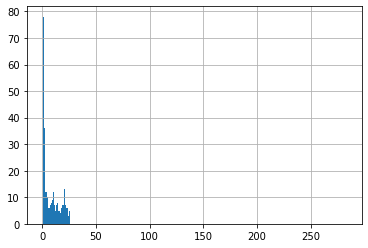

In [26]:
df['in_degree'] = in_degrees
df['in_degree'].hist(bins=range(n))
df['in_degree'].describe()

### c. Out-degree

In [27]:
out_degrees = []
for v in g.vertices():
    out_degrees.append(v.out_degree())

count    284.000000
mean       8.140845
std       11.417606
min        0.000000
25%        0.000000
50%        2.000000
75%       13.250000
max       47.000000
Name: out_degree, dtype: float64

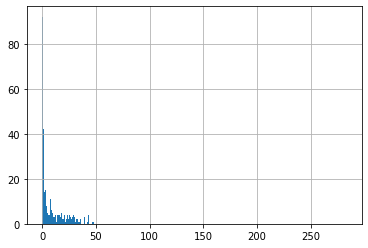

In [28]:
df['out_degree'] = out_degrees
df['out_degree'].hist(bins=range(n))
df['out_degree'].describe()

### d. Degree

In [29]:
degrees = []
for indeg, outdeg in zip(in_degrees, out_degrees):
    degrees.append(indeg + outdeg)

count    284.000000
mean      16.281690
std       17.911587
min        1.000000
25%        2.000000
50%        6.500000
75%       31.250000
max       61.000000
Name: degree, dtype: float64

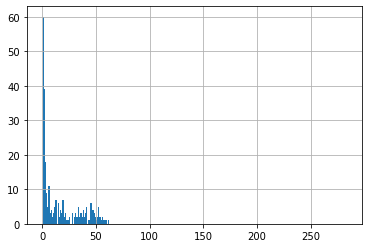

In [30]:
df['degree'] = degrees
df['degree'].hist(bins=range(n))
df['degree'].describe()